# Parkinsons Disease Detection with FBANKs and xvectors

using: 
- Adam optimizer with linear schedular.
- Global normalization; computes a single normalization vector for all the dataset
- Negative LogLikelihood loss.

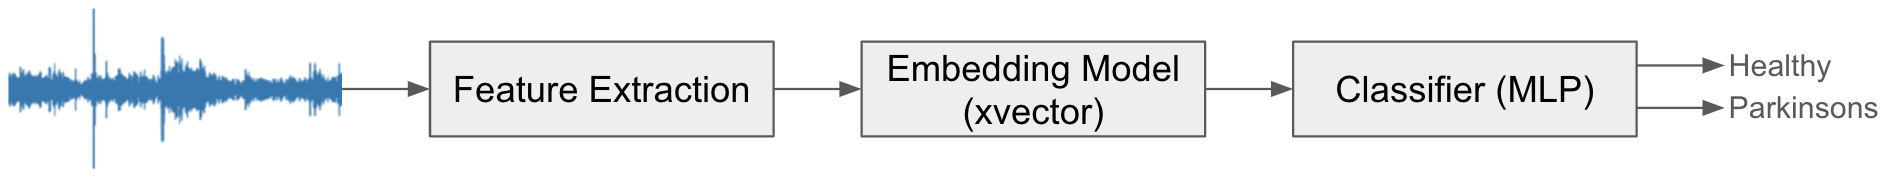

The x-vector model implemented in SpeechBrain is a deep neural network architecture designed to extract speaker-discriminative embeddings from speech signals. It operates on acoustic features such as Mel-Frequency Cepstral Coefficients (MFCCs) or log-Mel spectrograms, which are passed through a series of Time-Delay Neural Network (TDNN) layers to model temporal dependencies at the frame level. A statistical pooling layer then aggregates these frame-level representations by computing their mean and standard deviation, producing a fixed-dimensional segment-level embedding known as an x-vector. This embedding encapsulates speaker-specific characteristics and is well-suited for downstream tasks such as speaker recognition, speaker verification, and has also been leveraged in paralinguistic and clinical applications, including speech-based diagnosis of Parkinson’s disease. The modular implementation in SpeechBrain allows for straightforward integration and fine-tuning.[1]

[1] D. Snyder, D. Garcia-Romero, G. Sell, D. Povey and S. Khudanpur, "X-Vectors: Robust DNN Embeddings for Speaker Recognition," 2018 IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP), Calgary, AB, Canada, 2018, pp. 5329-5333, doi: 10.1109/ICASSP.2018.8461375.

The following diagram shows the xvector model architecture:


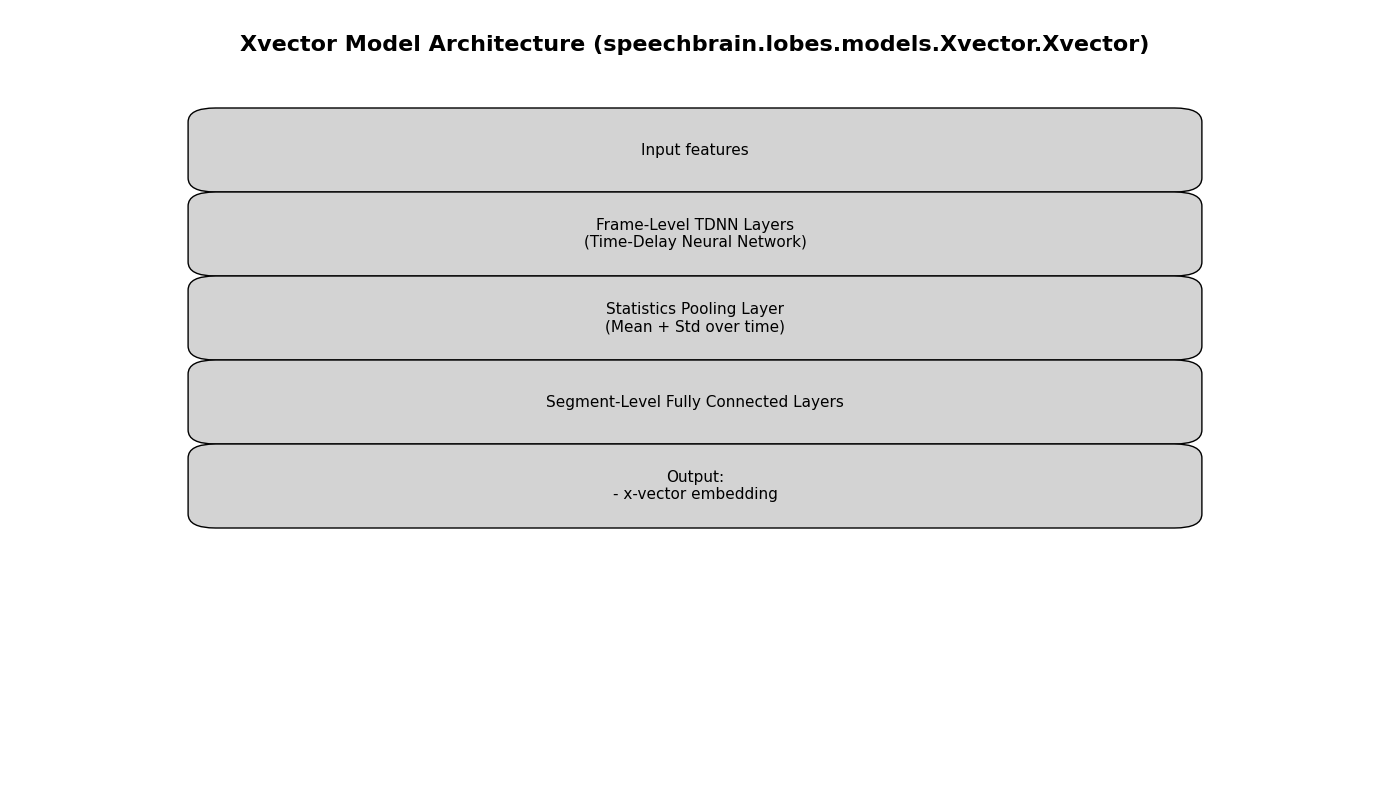

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_xvector_diagram():
    fig, ax = plt.subplots(figsize=(14, 8))

    # Title
    ax.text(0.5, 1.05, 'Xvector Model Architecture (speechbrain.lobes.models.Xvector.Xvector)', 
            ha='center', va='center', fontsize=16, fontweight='bold')

    # Block positions
    y = 0.9
    height = 0.08
    spacing = 0.12

    blocks = [
        ("Input features", 0.5, y),
        ("Frame-Level TDNN Layers\n(Time-Delay Neural Network)", 0.5, y - spacing),
        ("Statistics Pooling Layer\n(Mean + Std over time)", 0.5, y - 2 * spacing),
        ("Segment-Level Fully Connected Layers", 0.5, y - 3 * spacing),
        ("Output:\n- x-vector embedding", 0.5, y - 4 * spacing)
    ]

    for label, x, y_pos in blocks:
        rect = patches.FancyBboxPatch((x - 0.35, y_pos - height / 2), 0.7, height,
                                      boxstyle="round,pad=0.02", edgecolor="black", facecolor="lightgrey") # #add8e6
        ax.add_patch(rect)
        ax.text(x, y_pos, label, ha='center', va='center', fontsize=11)

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1.1)
    ax.axis('off')

    plt.tight_layout()
    plt.show()

draw_xvector_diagram()


## Results:

---
The table shows the test accuracy% of Xvector on different tasks with different input features:
| Dataset | FBANKs | MFCCs | Spectrograms | STFT | Waveform |
| -------------- | --- | --- | --- | --- | --- |
| Full Dataset | 99.0 |  |  |  |  |
| vowels | 100 |  |  |  |  |
| vowel-a | 100 |  |  |  |  |
| phrases | 100 |  |  |  |  |

---

## [1] Using FBANKs Input Features

### Full Dataset

#### hparams file

In [1]:
%%file hparams_xvector_fbanks.yaml

# Your code here
# #################################
# Basic training parameters for digit classification with Xvector
#
# Author:
#  * Mirco Ravanelli 2021
# #################################

# Seed needs to be set at top of yaml, before objects with parameters are made
seed: 1986
__set_seed: !!python/object/apply:torch.manual_seed [!ref <seed>]

data_folder: !ref /home/ulaval.ca/maelr5/scratch/parkinsons
output_folder: !ref /home/ulaval.ca/maelr5/scratch/parkinsons-results/xvector/fulldataset/FBANKs/<seed>
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# Path where data manifest files are stored
train_annotation: /home/ulaval.ca/maelr5/parkinsons/train.json
valid_annotation: /home/ulaval.ca/maelr5/parkinsons/valid.json
test_annotation: /home/ulaval.ca/maelr5/parkinsons/test.json

# The train logger writes training statistics to a file, as well as stdout.
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

error_stats: !name:speechbrain.utils.metric_stats.MetricStats
    metric: !name:speechbrain.nnet.losses.classification_error
        reduction: batch

# Feature parameters
n_mels: 40

# Training Parameters
sample_rate: 16000
number_of_epochs: 25
batch_size: 12
lr_start: 0.001
lr_final: 0.0001
n_classes: 2
emb_dim: 128 # dimensionality of the embeddings
train_dataloader_options:
    batch_size: !ref <batch_size>
    shuffle: True
    drop_last: True
eval_dataloader_options:
    batch_size: !ref <batch_size>
    shuffle: False
    drop_last: False

# Tensorboard logs
use_tensorboard: False
tensorboard_logs_folder: !ref <output_folder>/tb_logs/

# Feature extraction
compute_features: !new:speechbrain.lobes.features.Fbank
    n_mels: !ref <n_mels>

# Mean and std normalization of the input features
mean_var_norm: !new:speechbrain.processing.features.InputNormalization
    norm_type: global

# Embedding model: from variable size recordings gets a fixed size embedding vector
embedding_model: !new:speechbrain.lobes.models.Xvector.Xvector
    in_channels: !ref <n_mels>
    activation: !name:torch.nn.LeakyReLU
    tdnn_blocks: 5
    tdnn_channels: [64, 64, 64, 64, 128]
    tdnn_kernel_sizes: [5, 3, 3, 1, 1]
    tdnn_dilations: [1, 2, 3, 1, 1]
    lin_neurons: !ref <emb_dim>

# Clasifier applied on top of the embeddings
classifier: !new:speechbrain.lobes.models.Xvector.Classifier
    input_shape: [null, null, !ref <emb_dim>]
    activation: !name:torch.nn.LeakyReLU
    lin_blocks: 1
    lin_neurons: !ref <emb_dim>
    out_neurons: !ref <n_classes>

log_softmax: !new:speechbrain.nnet.activations.Softmax
    apply_log: True

# The first object passed to the Brain class is this "Epoch Counter"
# which is saved by the Checkpointer so that training can be resumed
# if it gets interrupted at any point.
epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

# Objects in "modules" dict will have their parameters moved to the correct
# device, as well as having train()/eval() called on them by the Brain class.
modules:
    compute_features: !ref <compute_features>
    mean_var_norm: !ref <mean_var_norm>
    embedding_model: !ref <embedding_model>
    classifier: !ref <classifier>

# This optimizer will be constructed by the Brain class after all parameters
# are moved to the correct device. Then it will be added to the checkpointer.
opt_class: !name:torch.optim.Adam
    lr: !ref <lr_start>

# This function manages learning rate annealing over the epochs.
# We here use the simple lr annealing method that linearly decreases
# the lr from the initial value to the final one.
lr_annealing: !new:speechbrain.nnet.schedulers.LinearScheduler
    initial_value: !ref <lr_start>
    final_value: !ref <lr_final>
    epoch_count: !ref <number_of_epochs>

# This object is used for saving the state of training both so that it
# can be resumed if it gets interrupted, and also so that the best checkpoint
# can be later loaded for evaluation or inference.
checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        embedding_model: !ref <embedding_model>
        classifier: !ref <classifier>
        normalizer: !ref <mean_var_norm>
        counter: !ref <epoch_counter>


Overwriting hparams_xvector_fbanks.yaml


#### train python file

In [8]:
%%file train_xvector_fbanks.py
# Your code here

#!/usr/bin/env python3
import os
import sys
import torch
import torchaudio
import speechbrain as sb
from hyperpyyaml import load_hyperpyyaml
from sklearn.metrics import confusion_matrix
from confusion_matrix_fig import create_cm_fig
import numpy as np


# Brain class for speech enhancement training
class DetectorBrain(sb.Brain):
    """Class that manages the training loop. See speechbrain.core.Brain."""

    def compute_forward(self, batch, stage):
        """Runs all the computations that transforms the input into the
        output probabilities over the N classes.

        Arguments
        ---------
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.
        Returns
        -------
        predictions : Tensor
            Tensor that contains the posterior probabilities over the N classes.
        """
        # Your code here. Aim for 7-8 lines
        batch = batch.to(self.device)

        # Feature extraction and normalization
        wavs, lens = batch.sig
        feats = self.modules.compute_features(wavs)
        feats = self.modules.mean_var_norm(feats, lens)

        embeddings = self.modules.embedding_model(feats, lens)
        predictions = self.modules.classifier(embeddings)
        predictions = self.hparams.log_softmax(predictions)

        return predictions


    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss given the predicted and targeted outputs.

        Arguments
        ---------
        predictions : tensor
            The output tensor from `compute_forward`.
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.
        Returns
        -------
        loss : torch.Tensor
            A one-element tensor used for backpropagating the gradient.
        """

        # Your code here. Aim for 7-8 lines
        _, lens = batch.sig
        detection_id, _ = batch.detection_id_encoded
        # print('prediction', predictions.shape)
        # print('detection_id', detection_id.shape)

        # Compute the cost function
        loss = sb.nnet.losses.nll_loss(predictions, detection_id, lens)

        # Append this batch of losses to the loss metric for easy
        self.loss_metric.append(
            batch.id, predictions, detection_id, lens, reduction="batch"
        )

        # Compute classification error at test time
        if stage != sb.Stage.TRAIN:
            self.error_metrics.append(batch.id, predictions, detection_id, lens)

        # Confusion matrices
        if stage != sb.Stage.TRAIN:
            y_true = detection_id.cpu().detach().numpy().squeeze(-1)
            y_pred = predictions.cpu().detach().numpy().argmax(-1).squeeze(-1)
        if stage == sb.Stage.TEST:
            # print('test y_true= ', y_true)
            # print('test y_pred= ', y_pred)
            confusion_matix = confusion_matrix(
                y_true,
                y_pred,
                labels=sorted(self.hparams.label_encoder.ind2lab.keys()),
            )
            self.test_confusion_matrix += confusion_matix

        # Compute accuracy using MetricStats
        self.acc_metric.append(
            batch.id, predict=predictions, target=detection_id, lengths=lens
        )

        return loss


    def on_stage_start(self, stage, epoch=None):
        """Gets called at the beginning of each epoch.
        Arguments
        ---------
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.
        epoch : int
            The currently-starting epoch. This is passed
            `None` during the test stage.
        """

        # Set up statistics trackers for this stage
        self.loss_metric = sb.utils.metric_stats.MetricStats(
            metric=sb.nnet.losses.nll_loss
        )

        # Compute accuracy using MetricStats
        # Define function taking (prediction, target, length) for eval
        def accuracy_value(predict, target, lengths):
            """Computes accuracy."""
            # print("Predictions shape:", predict.shape)
            # print("Detection ID shape:", target.shape)
            # print("Lengths shape:", lengths.shape)
            nbr_correct, nbr_total = sb.utils.Accuracy.Accuracy(
                predict, target, lengths
            )
            acc = torch.tensor([nbr_correct / nbr_total])
            return acc

        self.acc_metric = sb.utils.metric_stats.MetricStats(
            metric=accuracy_value, n_jobs=1
        )
        if stage == sb.Stage.TEST:
            self.test_confusion_matrix = np.zeros(
                shape=(self.hparams.n_classes, self.hparams.n_classes),
                dtype=int,
            )

        # Set up evaluation-only statistics trackers
        if stage != sb.Stage.TRAIN:
            self.error_metrics = self.hparams.error_stats()

    def on_stage_end(self, stage, stage_loss, epoch=None):
        """Gets called at the end of an epoch.
        Arguments
        ---------
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, sb.Stage.TEST
        stage_loss : float
            The average loss for all of the data processed in this stage.
        epoch : int
            The currently-starting epoch. This is passed
            `None` during the test stage.
        """

        # Store the train loss until the validation stage.
        if stage == sb.Stage.TRAIN:
            self.train_loss = stage_loss
            self.train_stats = {
                "loss": self.train_loss,
                "acc": self.acc_metric.summarize("average"),
            }

        # Summarize the statistics from the stage for record-keeping.
        elif stage == sb.Stage.VALID:
            valid_stats = {
                "loss": stage_loss,
                "acc": self.acc_metric.summarize("average"),
                "error": self.error_metrics.summarize("average"),
            }
        # Summarize Test statistics from the stage for record-keeping
        else:
            test_stats = {
                "loss": stage_loss,
                "acc": self.acc_metric.summarize("average"),
                "error": self.error_metrics.summarize("average"),
            }

        # At the end of validation...
        if stage == sb.Stage.VALID:
            old_lr, new_lr = self.hparams.lr_annealing(epoch)
            sb.nnet.schedulers.update_learning_rate(self.optimizer, new_lr)

            # Tensorboard logging
            if self.hparams.use_tensorboard:
                self.hparams.tensorboard_train_logger.log_stats(
                    stats_meta={"Epoch": epoch},
                    train_stats=self.train_stats,
                    valid_stats=valid_stats,
                )

            # The train_logger writes a summary to stdout and to the logfile.
            self.hparams.train_logger.log_stats(
                {"Epoch": epoch, "lr": old_lr},
                train_stats=self.train_stats,
                valid_stats=valid_stats,
            )

            # Save the current checkpoint and delete previous checkpoints,
            self.checkpointer.save_and_keep_only(meta=valid_stats, min_keys=["error"])

        # We also write statistics about test data to stdout and to the logfile.
        if stage == sb.Stage.TEST:
            # self.hparams.train_logger.log_stats(
            #     {"Epoch loaded": self.hparams.epoch_counter.current},
            #     test_stats=stats,
            # )
            # Per class accuracy from Test confusion matrix
            per_class_acc_arr = np.diag(self.test_confusion_matrix) / np.sum(
                self.test_confusion_matrix, axis=1
            )
            per_class_acc_arr_str = "\n" + "\n".join(
                "{:}: {:.3f}".format(class_id, class_acc)
                for class_id, class_acc in enumerate(per_class_acc_arr)
            )

            self.hparams.train_logger.log_stats(
                {
                    "Epoch loaded": self.hparams.epoch_counter.current,
                    "\n Per Class Accuracy": per_class_acc_arr_str,
                    "\n Confusion Matrix": "\n{:}\n".format(
                        self.test_confusion_matrix
                    ),
                },
                test_stats=test_stats,
            )


def dataio_prep(hparams):
    """This function prepares the datasets to be used in the brain class.
    It also defines the data processing pipeline through user-defined functions.
    We expect `prepare_mini_librispeech` to have been called before this,
    so that the `train.json`, `valid.json`,  and `valid.json` manifest files
    are available.
    Arguments
    ---------
    hparams : dict
        This dictionary is loaded from the `train.yaml` file, and it includes
        all the hyperparameters needed for dataset construction and loading.
    Returns
    -------
    datasets : dict
        Contains two keys, "train" and "valid" that correspond
        to the appropriate DynamicItemDataset object.
    """

    # Initialization of the label encoder. The label encoder assigns to each
    # of the observed label a unique index (e.g, 'digit0': 0, 'digit1': 1, ..)
    label_encoder = sb.dataio.encoder.CategoricalEncoder()

    # Define audio pipeline
    @sb.utils.data_pipeline.takes("path")
    @sb.utils.data_pipeline.provides("sig")
    def audio_pipeline(wav):
        """Load the signal, and pass it and its length to the corruption class.
        This is done on the CPU in the `collate_fn`."""
        sig, fs = torchaudio.load(wav)

        # Resampling
        # print('input signal(s) shape: ', sig.squeeze().shape)
        sig = torchaudio.functional.resample(sig.squeeze(0), fs, hparams["sample_rate"])
        return sig

    # Define label pipeline:
    @sb.utils.data_pipeline.takes("detection")
    @sb.utils.data_pipeline.provides("detection", "detection_id_encoded")
    def label_pipeline(detection_id):
        """Defines the pipeline to process the detection labels.
        Note that we have to assign a different integer to each class
        through the label encoder.
        """
        yield detection_id
        detection_id_encoded = label_encoder.encode_label_torch(detection_id)
        yield detection_id_encoded

    # Define datasets. We also connect the dataset with the data processing
    # functions defined above.
    datasets = {}
    data_info = {
        "train": hparams["train_annotation"],
        "valid": hparams["valid_annotation"],
        "test": hparams["test_annotation"],
    }
    # hparams["dataloader_options"]["shuffle"] = True
    for dataset in data_info:
        datasets[dataset] = sb.dataio.dataset.DynamicItemDataset.from_json(
            json_path=data_info[dataset],
            dynamic_items=[audio_pipeline, label_pipeline],
            output_keys=["id", "sig", "detection_id_encoded"],
        )

    # Load or compute the label encoder (with multi-GPU DDP support)
    # Please, take a look into the lab_enc_file to see the label to index
    # mapping.
    lab_enc_file = os.path.join(hparams["save_folder"], "label_encoder.txt")
    label_encoder.load_or_create(
        path=lab_enc_file,
        from_didatasets=[datasets["train"]],
        output_key="detection",
    )

    return datasets, label_encoder


# Recipe begins!
if __name__ == "__main__":

    # Reading command line arguments.
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])

    # Load hyperparameters file with command-line overrides.
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin,  overrides)

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # Tensorboard logging
    if hparams["use_tensorboard"]:
        from speechbrain.utils.train_logger import TensorboardLogger

        hparams["tensorboard_train_logger"] = TensorboardLogger(
            hparams["tensorboard_logs_folder"]
        )

    # Create dataset objects "train", "valid", and "test".
    datasets, label_encoder = dataio_prep(hparams)
    
    hparams["label_encoder"] = label_encoder
    class_labels = sorted(list(label_encoder.ind2lab.values()))
    print("Class Labels:", class_labels, list(label_encoder.lab2ind.values()))

    # Initialize the Brain object to prepare for mask training.
    detection_brain = DetectorBrain(
        modules=hparams["modules"],
        opt_class=hparams["opt_class"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    # The `fit()` method iterates the training loop, calling the methods
    # necessary to update the parameters of the model. Since all objects
    # with changing state are managed by the Checkpointer, training can be
    # stopped at any point, and will be resumed on next call.
    detection_brain.fit(
        epoch_counter=detection_brain.hparams.epoch_counter,
        train_set=datasets["train"],
        valid_set=datasets["valid"],
        train_loader_kwargs=hparams["train_dataloader_options"],
        valid_loader_kwargs=hparams["eval_dataloader_options"],
    )

    # Load the best checkpoint for evaluation
    test_stats = detection_brain.evaluate(
        test_set=datasets["test"],
        min_key="error",
        test_loader_kwargs=hparams["eval_dataloader_options"],
    )



Overwriting train_xvector_fbanks.py


In [9]:
# Delete the output folder to start training from scratch (and not from a previous checkpoint).
!rm -rf /home/ulaval.ca/maelr5/scratch/parkinsons-results/xvector/fulldataset/FBANKs/1986

import sys
# Run Training
!{sys.executable} train_xvector_fbanks.py hparams_xvector_fbanks.yaml --device='cuda:0' --number_of_epochs=15 --use_tensorboard=True


/home/ulaval.ca/maelr5/parkinsons/parksenv/lib/python3.11/site-packages/speechbrain/utils/autocast.py:188: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)
speechbrain.utils.quirks - Applied quirks (see `speechbrain.utils.quirks`): [disable_jit_profiling, allow_tf32]
speechbrain.utils.quirks - Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: /home/ulaval.ca/maelr5/scratch/parkinsons-results/xvector/fulldataset/FBANKs/1986
2025-04-20 04:45:50.297008: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-20 04:45:50.321630: E external/local_xla/xla/stream_executor/cuda/cuda_d

output log train:
```
Epoch: 1, lr: 1.00e-03 - train loss: 3.26e-01, train acc: 8.60e-01 - valid loss: 1.72e-01, valid acc: 9.44e-01, valid error: 6.25e-02
Epoch: 2, lr: 9.36e-04 - train loss: 1.91e-01, train acc: 9.24e-01 - valid loss: 9.05e-01, valid acc: 7.08e-01, valid error: 2.97e-01
Epoch: 3, lr: 8.71e-04 - train loss: 1.45e-01, train acc: 9.51e-01 - valid loss: 6.68e-02, valid acc: 9.58e-01, valid error: 4.69e-02
Epoch: 4, lr: 8.07e-04 - train loss: 1.52e-01, train acc: 9.44e-01 - valid loss: 1.18e-01, valid acc: 9.86e-01, valid error: 1.56e-02
Epoch: 5, lr: 7.43e-04 - train loss: 9.65e-02, train acc: 9.66e-01 - valid loss: 2.85e-02, valid acc: 1.00e+00, valid error: 0.00e+00
Epoch: 6, lr: 6.79e-04 - train loss: 1.08e-01, train acc: 9.65e-01 - valid loss: 5.19e-02, valid acc: 9.86e-01, valid error: 1.56e-02
Epoch: 7, lr: 6.14e-04 - train loss: 4.09e-02, train acc: 9.85e-01 - valid loss: 1.44e-01, valid acc: 9.58e-01, valid error: 4.69e-02
Epoch: 8, lr: 5.50e-04 - train loss: 3.97e-02, train acc: 9.85e-01 - valid loss: 1.04e-02, valid acc: 1.00e+00, valid error: 0.00e+00
Epoch: 9, lr: 4.86e-04 - train loss: 3.73e-02, train acc: 9.89e-01 - valid loss: 2.77e-02, valid acc: 9.86e-01, valid error: 1.56e-02
Epoch: 10, lr: 4.21e-04 - train loss: 4.32e-02, train acc: 9.92e-01 - valid loss: 9.32e-03, valid acc: 1.00e+00, valid error: 0.00e+00
Epoch: 11, lr: 3.57e-04 - train loss: 3.88e-02, train acc: 9.91e-01 - valid loss: 4.20e-02, valid acc: 1.00e+00, valid error: 0.00e+00
Epoch: 12, lr: 2.93e-04 - train loss: 3.14e-02, train acc: 9.91e-01 - valid loss: 1.47e-02, valid acc: 1.00e+00, valid error: 0.00e+00
Epoch: 13, lr: 2.29e-04 - train loss: 7.68e-02, train acc: 9.85e-01 - valid loss: 2.39e-02, valid acc: 9.86e-01, valid error: 1.56e-02
Epoch: 14, lr: 1.64e-04 - train loss: 2.92e-02, train acc: 9.95e-01 - valid loss: 2.14e-02, valid acc: 9.86e-01, valid error: 1.56e-02
Epoch: 15, lr: 1.00e-04 - train loss: 1.11e-02, train acc: 9.98e-01 - valid loss: 4.05e-02, valid acc: 9.72e-01, valid error: 3.12e-02
Epoch loaded: 12, 
 Per Class Accuracy: 
0: 1.000
1: 0.974, 
 Confusion Matrix: 
[[48  0]
 [ 1 37]]
 - test loss: 2.55e-02, test acc: 9.90e-01, test error: 1.16e-02
```

#### plot the train/valid loss/accuracy during training:

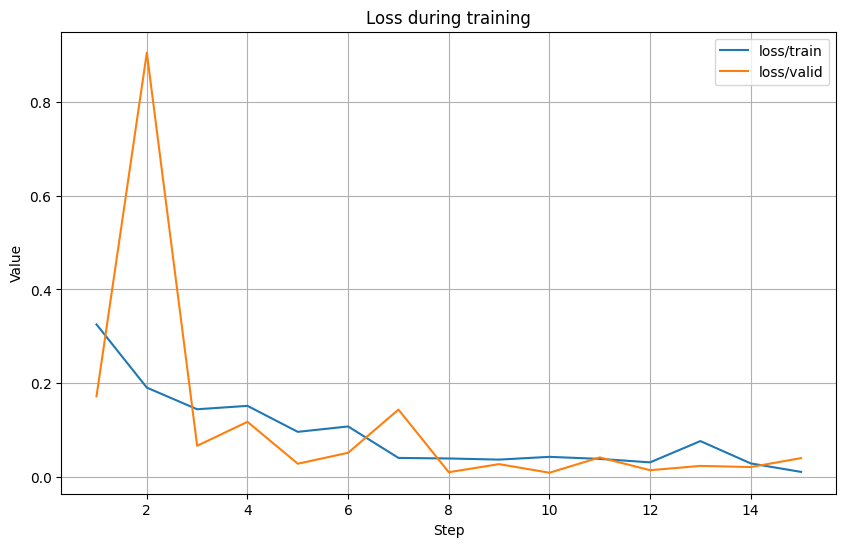

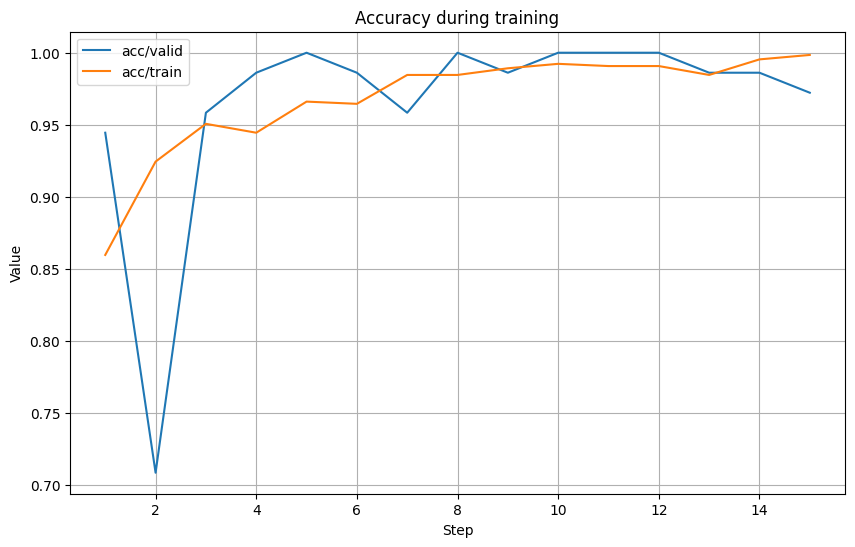

In [10]:
import tensorflow as tf
import matplotlib.pyplot as plt

def plot_training(event_file):
    # Extract data from the event file
    step = []  # Store the global steps
    values = []  # Store the values (e.g., loss or accuracy)
    tags = []  # Store the tags (e.g., "train_loss", "validation_accuracy")
    
    for summary in tf.compat.v1.train.summary_iterator(event_file):
        for value in summary.summary.value:
            # You can filter out the tags you're interested in (e.g., "train_loss", "accuracy")
            if value.HasField('simple_value'):  # Make sure it is a scalar value
                tags.append(value.tag)
                values.append(value.simple_value)
                step.append(summary.step)
    
    # Plot the loss
    plt.figure(figsize=(10, 6))
    
    # Example: Plotting a specific tag (e.g., "train_loss")
    for tag in set(tags):  # We loop through each unique tag
        # print(tag)
        if tag == 'error/valid':
            continue
        if tag == 'Epoch':
            continue
        if tag == 'acc/train':
            continue
        if tag == 'acc/valid':
            continue
        tag_indices = [i for i, t in enumerate(tags) if t == tag]
        tag_steps = [step[i] for i in tag_indices]
        tag_values = [values[i] for i in tag_indices]
        
        plt.plot(tag_steps, tag_values, label=tag)  # Plot each tag with its respective values
    
    # Customize plot
    plt.xlabel('Step')
    plt.ylabel('Value')
    plt.title('Loss during training')
    plt.legend()
    plt.grid(True)
    
    # Show plot
    plt.show()
    
    # Plot the acc
    plt.figure(figsize=(10, 6))
    
    # Example: Plotting a specific tag (e.g., "train_loss")
    for tag in set(tags):  # We loop through each unique tag
        # print(tag)
        if tag == 'error/valid':
            continue
        if tag == 'Epoch':
            continue
        if tag == 'loss/train':
            continue
        if tag == 'loss/valid':
            continue
        tag_indices = [i for i, t in enumerate(tags) if t == tag]
        tag_steps = [step[i] for i in tag_indices]
        tag_values = [values[i] for i in tag_indices]
        
        plt.plot(tag_steps, tag_values, label=tag)  # Plot each tag with its respective values
    
    # Customize plot
    plt.xlabel('Step')
    plt.ylabel('Value')
    plt.title('Accuracy during training')
    plt.legend()
    plt.grid(True)
    
    # Show plot
    plt.show()

event_file = "/home/ulaval.ca/maelr5/scratch/parkinsons-results/xvector/fulldataset/FBANKs/1986/tb_logs/events.out.tfevents.1745138757.ul-val-pr-gpu05.l.ul.ca.1159741.0"
plot_training(event_file)



#### sanity checks

(1) The following output happens when testing the model without training (random mdoel), and the error is high which it means:

- The evaluation pipeline is working correctly.

- The model is not stuck predicting a single class (otherwise you'd see either near-100% or near-0%).

- There is no major data leakage (otherwise the untrained model would not perform so well).

- Test set is balanced (or at least not super imbalanced), since a random model gets ~50%.

In [6]:
# Delete the output folder to start training from scratch (and not from a previous checkpoint).
!rm -rf /home/ulaval.ca/maelr5/scratch/parkinsons-results/xvector/fulldataset/FBANKs/1986

import sys
# Run Training
!{sys.executable} train_xvector_fbanks.py hparams_xvector_fbanks.yaml --device='cuda:0' --number_of_epochs=25 --use_tensorboard=True


/home/ulaval.ca/maelr5/parkinsons/parksenv/lib/python3.11/site-packages/speechbrain/utils/autocast.py:188: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)
speechbrain.utils.quirks - Applied quirks (see `speechbrain.utils.quirks`): [disable_jit_profiling, allow_tf32]
speechbrain.utils.quirks - Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: /home/ulaval.ca/maelr5/scratch/parkinsons-results/xvector/fulldataset/FBANKs/1986
2025-04-20 04:37:05.867974: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-20 04:37:05.891854: E external/local_xla/xla/stream_executor/cuda/cuda_d

(2) Train n small train data:


In [2]:
%%file hparams_xvector_sanitycheck_fbanks.yaml

# Your code here
# #################################
# Basic training parameters for digit classification with Xvector
#
# Author:
#  * Mirco Ravanelli 2021
# #################################

# Seed needs to be set at top of yaml, before objects with parameters are made
seed: 1986
__set_seed: !!python/object/apply:torch.manual_seed [!ref <seed>]

data_folder: !ref /home/ulaval.ca/maelr5/scratch/parkinsons
output_folder: !ref /home/ulaval.ca/maelr5/scratch/parkinsons-results/xvector/sanitycheck/FBANKs/<seed>
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# Path where data manifest files are stored
train_annotation: /home/ulaval.ca/maelr5/parkinsons/train-check.json
valid_annotation: /home/ulaval.ca/maelr5/parkinsons/valid-check.json
test_annotation: /home/ulaval.ca/maelr5/parkinsons/test.json

# The train logger writes training statistics to a file, as well as stdout.
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

error_stats: !name:speechbrain.utils.metric_stats.MetricStats
    metric: !name:speechbrain.nnet.losses.classification_error
        reduction: batch

# Feature parameters
n_mels: 40

# Training Parameters
sample_rate: 16000
number_of_epochs: 25
batch_size: 12
lr_start: 0.001
lr_final: 0.0001
n_classes: 2
emb_dim: 128 # dimensionality of the embeddings
train_dataloader_options:
    batch_size: !ref <batch_size>
    shuffle: True
    drop_last: True
eval_dataloader_options:
    batch_size: !ref <batch_size>
    shuffle: False
    drop_last: False

# Tensorboard logs
use_tensorboard: False
tensorboard_logs_folder: !ref <output_folder>/tb_logs/

# Feature extraction
compute_features: !new:speechbrain.lobes.features.Fbank
    n_mels: !ref <n_mels>

# Mean and std normalization of the input features
mean_var_norm: !new:speechbrain.processing.features.InputNormalization
    norm_type: global

# Embedding model: from variable size recordings gets a fixed size embedding vector
embedding_model: !new:speechbrain.lobes.models.Xvector.Xvector
    in_channels: !ref <n_mels>
    activation: !name:torch.nn.LeakyReLU
    tdnn_blocks: 5
    tdnn_channels: [64, 64, 64, 64, 128]
    tdnn_kernel_sizes: [5, 3, 3, 1, 1]
    tdnn_dilations: [1, 2, 3, 1, 1]
    lin_neurons: !ref <emb_dim>

# Clasifier applied on top of the embeddings
classifier: !new:speechbrain.lobes.models.Xvector.Classifier
    input_shape: [null, null, !ref <emb_dim>]
    activation: !name:torch.nn.LeakyReLU
    lin_blocks: 1
    lin_neurons: !ref <emb_dim>
    out_neurons: !ref <n_classes>

log_softmax: !new:speechbrain.nnet.activations.Softmax
    apply_log: True

# The first object passed to the Brain class is this "Epoch Counter"
# which is saved by the Checkpointer so that training can be resumed
# if it gets interrupted at any point.
epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

# Objects in "modules" dict will have their parameters moved to the correct
# device, as well as having train()/eval() called on them by the Brain class.
modules:
    compute_features: !ref <compute_features>
    mean_var_norm: !ref <mean_var_norm>
    embedding_model: !ref <embedding_model>
    classifier: !ref <classifier>

# This optimizer will be constructed by the Brain class after all parameters
# are moved to the correct device. Then it will be added to the checkpointer.
opt_class: !name:torch.optim.Adam
    lr: !ref <lr_start>

# This function manages learning rate annealing over the epochs.
# We here use the simple lr annealing method that linearly decreases
# the lr from the initial value to the final one.
lr_annealing: !new:speechbrain.nnet.schedulers.LinearScheduler
    initial_value: !ref <lr_start>
    final_value: !ref <lr_final>
    epoch_count: !ref <number_of_epochs>

# This object is used for saving the state of training both so that it
# can be resumed if it gets interrupted, and also so that the best checkpoint
# can be later loaded for evaluation or inference.
checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        embedding_model: !ref <embedding_model>
        classifier: !ref <classifier>
        normalizer: !ref <mean_var_norm>
        counter: !ref <epoch_counter>


Writing hparams_xvector_sanitycheck_fbanks.yaml


using the train_xvector_fbanks.py script for training:

In [7]:
# Delete the output folder to start training from scratch (and not from a previous checkpoint).
!rm -rf /home/ulaval.ca/maelr5/scratch/parkinsons-results/xvector/sanitycheck/FBANKs/1986

import sys
# Run Training
!{sys.executable} train_xvector_fbanks.py hparams_xvector_sanitycheck_fbanks.yaml --device='cuda:0' --number_of_epochs=15 --use_tensorboard=True


/home/ulaval.ca/maelr5/parkinsons/parksenv/lib/python3.11/site-packages/speechbrain/utils/autocast.py:188: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)
speechbrain.utils.quirks - Applied quirks (see `speechbrain.utils.quirks`): [disable_jit_profiling, allow_tf32]
speechbrain.utils.quirks - Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: /home/ulaval.ca/maelr5/scratch/parkinsons-results/xvector/sanitycheck/FBANKs/1986
2025-04-20 14:21:04.674390: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-20 14:21:04.696871: E external/local_xla/xla/stream_executor/cuda/cuda_d

From the following output of training the model on small data of 20 train and 4 valid (class balanced):
```
Epoch: 1, lr: 1.00e-03 - train loss: 9.31e-01, train acc: 4.17e-01 - valid loss: 6.94e-01, valid acc: 5.00e-01, valid error: 5.00e-01
Epoch: 2, lr: 9.36e-04 - train loss: 4.70e-01, train acc: 7.50e-01 - valid loss: 6.95e-01, valid acc: 5.00e-01, valid error: 5.00e-01
Epoch: 3, lr: 8.71e-04 - train loss: 3.32e-01, train acc: 9.17e-01 - valid loss: 6.97e-01, valid acc: 5.00e-01, valid error: 5.00e-01
Epoch: 4, lr: 8.07e-04 - train loss: 2.06e-01, train acc: 9.17e-01 - valid loss: 6.99e-01, valid acc: 5.00e-01, valid error: 5.00e-01
Epoch: 5, lr: 7.43e-04 - train loss: 2.53e-01, train acc: 8.33e-01 - valid loss: 7.02e-01, valid acc: 5.00e-01, valid error: 5.00e-01
Epoch: 6, lr: 6.79e-04 - train loss: 1.94e-01, train acc: 1.00e+00 - valid loss: 7.05e-01, valid acc: 5.00e-01, valid error: 5.00e-01
Epoch: 7, lr: 6.14e-04 - train loss: 1.74e-01, train acc: 1.00e+00 - valid loss: 7.10e-01, valid acc: 5.00e-01, valid error: 5.00e-01
Epoch: 8, lr: 5.50e-04 - train loss: 8.31e-02, train acc: 1.00e+00 - valid loss: 7.16e-01, valid acc: 5.00e-01, valid error: 5.00e-01
Epoch: 9, lr: 4.86e-04 - train loss: 6.33e-02, train acc: 1.00e+00 - valid loss: 7.25e-01, valid acc: 5.00e-01, valid error: 5.00e-01
Epoch: 10, lr: 4.21e-04 - train loss: 5.70e-02, train acc: 1.00e+00 - valid loss: 7.35e-01, valid acc: 5.00e-01, valid error: 5.00e-01
Epoch: 11, lr: 3.57e-04 - train loss: 4.16e-02, train acc: 1.00e+00 - valid loss: 7.49e-01, valid acc: 5.00e-01, valid error: 5.00e-01
Epoch: 12, lr: 2.93e-04 - train loss: 8.00e-02, train acc: 1.00e+00 - valid loss: 7.71e-01, valid acc: 5.00e-01, valid error: 5.00e-01
Epoch: 13, lr: 2.29e-04 - train loss: 2.94e-02, train acc: 1.00e+00 - valid loss: 7.86e-01, valid acc: 5.00e-01, valid error: 5.00e-01
Epoch: 14, lr: 1.64e-04 - train loss: 3.52e-02, train acc: 1.00e+00 - valid loss: 7.97e-01, valid acc: 5.00e-01, valid error: 5.00e-01
Epoch: 15, lr: 1.00e-04 - train loss: 2.53e-02, train acc: 1.00e+00 - valid loss: 8.11e-01, valid acc: 5.00e-01, valid error: 5.00e-01
Epoch loaded: 15, 
 Per Class Accuracy: 
0: 1.000
1: 0.000, 
 Confusion Matrix: 
[[48  0]
 [38  0]]
 - test loss: 7.70e-01, test acc: 5.52e-01, test error: 4.42e-01
```
- The model overfits the train data and fails to generalize. So, the training pipeline is working.


#### Repeated Random Split

### Vowels Data

#### hparams file

In [22]:
%%file hparams_xvector_vowels_fbanks.yaml

# Your code here
# #################################
# Basic training parameters for digit classification with Xvector
#
# Author:
#  * Mirco Ravanelli 2021
# #################################

# Seed needs to be set at top of yaml, before objects with parameters are made
seed: 1986
__set_seed: !!python/object/apply:torch.manual_seed [!ref <seed>]

data_folder: !ref /home/ulaval.ca/maelr5/scratch/parkinsons
output_folder: !ref /home/ulaval.ca/maelr5/scratch/parkinsons-results/xvector/vowels/FBANKs/<seed>
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# Path where data manifest files are stored
train_annotation: /home/ulaval.ca/maelr5/parkinsons/train-vowels.json
valid_annotation: /home/ulaval.ca/maelr5/parkinsons/valid-vowels.json
test_annotation: /home/ulaval.ca/maelr5/parkinsons/test-vowels.json

# The train logger writes training statistics to a file, as well as stdout.
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

error_stats: !name:speechbrain.utils.metric_stats.MetricStats
    metric: !name:speechbrain.nnet.losses.classification_error
        reduction: batch

# Feature parameters
n_mels: 40

# Training Parameters
sample_rate: 16000
number_of_epochs: 25
batch_size: 12
lr_start: 0.001
lr_final: 0.0001
n_classes: 2
emb_dim: 128 # dimensionality of the embeddings
dataloader_options:
    batch_size: !ref <batch_size>

# Tensorboard logs
use_tensorboard: False
tensorboard_logs_folder: !ref <output_folder>/tb_logs/

# Feature extraction
compute_features: !new:speechbrain.lobes.features.Fbank
    n_mels: !ref <n_mels>

# Mean and std normalization of the input features
mean_var_norm: !new:speechbrain.processing.features.InputNormalization
    norm_type: global

# Embedding model: from variable size recordings gets a fixed size embedding vector
embedding_model: !new:speechbrain.lobes.models.Xvector.Xvector
    in_channels: !ref <n_mels>
    activation: !name:torch.nn.LeakyReLU
    tdnn_blocks: 5
    tdnn_channels: [64, 64, 64, 64, 128]
    tdnn_kernel_sizes: [5, 3, 3, 1, 1]
    tdnn_dilations: [1, 2, 3, 1, 1]
    lin_neurons: !ref <emb_dim>

# Clasifier applied on top of the embeddings
classifier: !new:speechbrain.lobes.models.Xvector.Classifier
    input_shape: [null, null, !ref <emb_dim>]
    activation: !name:torch.nn.LeakyReLU
    lin_blocks: 1
    lin_neurons: !ref <emb_dim>
    out_neurons: !ref <n_classes>

log_softmax: !new:speechbrain.nnet.activations.Softmax
    apply_log: True

# The first object passed to the Brain class is this "Epoch Counter"
# which is saved by the Checkpointer so that training can be resumed
# if it gets interrupted at any point.
epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

# Objects in "modules" dict will have their parameters moved to the correct
# device, as well as having train()/eval() called on them by the Brain class.
modules:
    compute_features: !ref <compute_features>
    mean_var_norm: !ref <mean_var_norm>
    embedding_model: !ref <embedding_model>
    classifier: !ref <classifier>

# This optimizer will be constructed by the Brain class after all parameters
# are moved to the correct device. Then it will be added to the checkpointer.
opt_class: !name:torch.optim.Adam
    lr: !ref <lr_start>

# This function manages learning rate annealing over the epochs.
# We here use the simple lr annealing method that linearly decreases
# the lr from the initial value to the final one.
lr_annealing: !new:speechbrain.nnet.schedulers.LinearScheduler
    initial_value: !ref <lr_start>
    final_value: !ref <lr_final>
    epoch_count: !ref <number_of_epochs>

# This object is used for saving the state of training both so that it
# can be resumed if it gets interrupted, and also so that the best checkpoint
# can be later loaded for evaluation or inference.
checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        embedding_model: !ref <embedding_model>
        classifier: !ref <classifier>
        normalizer: !ref <mean_var_norm>
        counter: !ref <epoch_counter>


Overwriting hparams_xvector_vowels_fbanks.yaml


#### train python file

We can use the same train_xvector_fbanks.py script for training

In [18]:
# Delete the output folder to start training from scratch (and not from a previous checkpoint).
# !rm -rf /home/ulaval.ca/maelr5/scratch/parkinsons-results/xvector/FBANKs/1986

import sys
# Run Training
!{sys.executable} train_xvector_fbanks.py hparams_xvector_vowels_fbanks.yaml --device='cuda:0' --number_of_epochs=25 --use_tensorboard=True


/home/ulaval.ca/maelr5/parkinsons/parksenv/lib/python3.11/site-packages/speechbrain/utils/autocast.py:188: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)
speechbrain.utils.quirks - Applied quirks (see `speechbrain.utils.quirks`): [allow_tf32, disable_jit_profiling]
speechbrain.utils.quirks - Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: /home/ulaval.ca/maelr5/scratch/parkinsons-results/xvector/vowels/FBANKs/1986
2025-04-19 17:14:23.760056: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-19 17:14:23.783174: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc

#### plot the train/valid loss/accuracy during training:

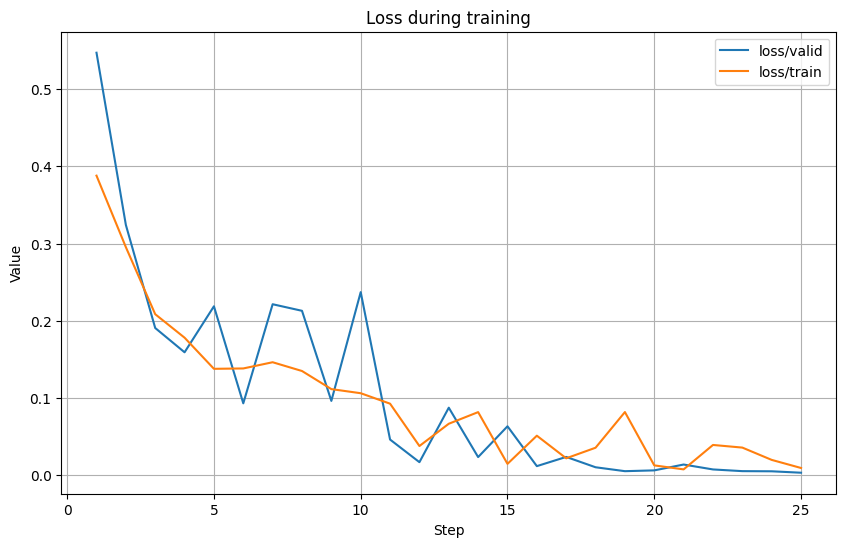

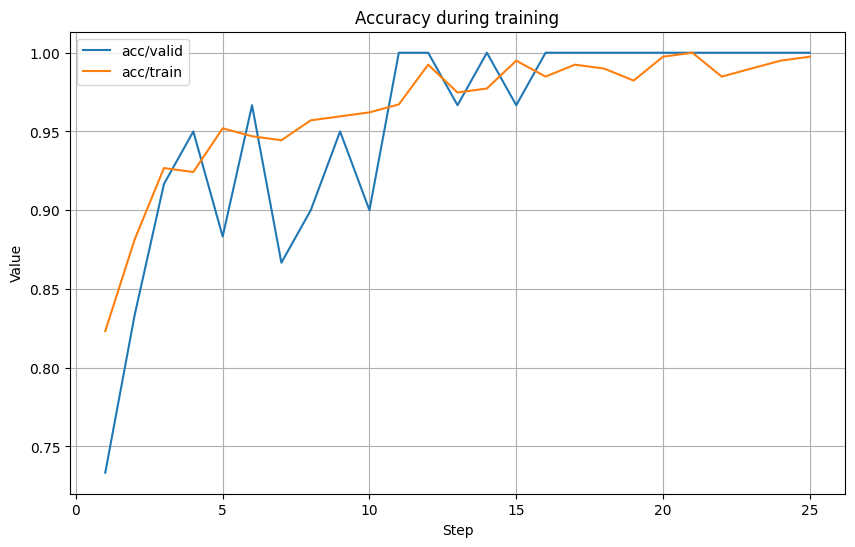

In [20]:
event_file = "/home/ulaval.ca/maelr5/scratch/parkinsons-results/xvector/vowels/FBANKs/1986/tb_logs/events.out.tfevents.1745097272.ul-val-pr-gpu05.l.ul.ca.1009019.0"
plot_training(event_file)



### Vowel-a Data

#### hparams file

In [27]:
%%file hparams_xvector_vowel_a_fbanks.yaml

# Your code here
# #################################
# Basic training parameters for digit classification with Xvector
#
# Author:
#  * Mirco Ravanelli 2021
# #################################

# Seed needs to be set at top of yaml, before objects with parameters are made
seed: 1986
__set_seed: !!python/object/apply:torch.manual_seed [!ref <seed>]

data_folder: !ref /home/ulaval.ca/maelr5/scratch/parkinsons
output_folder: !ref /home/ulaval.ca/maelr5/scratch/parkinsons-results/xvector/vowel_a/FBANKs/<seed>
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# Path where data manifest files are stored
train_annotation: /home/ulaval.ca/maelr5/parkinsons/train-vowel-a.json
valid_annotation: /home/ulaval.ca/maelr5/parkinsons/valid-vowel-a.json
test_annotation: /home/ulaval.ca/maelr5/parkinsons/test-vowel-a.json

# The train logger writes training statistics to a file, as well as stdout.
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

error_stats: !name:speechbrain.utils.metric_stats.MetricStats
    metric: !name:speechbrain.nnet.losses.classification_error
        reduction: batch

# Feature parameters
n_mels: 40

# Training Parameters
sample_rate: 16000
number_of_epochs: 25
batch_size: 12
lr_start: 0.001
lr_final: 0.0001
n_classes: 2
emb_dim: 128 # dimensionality of the embeddings
dataloader_options:
    batch_size: !ref <batch_size>

# Tensorboard logs
use_tensorboard: False
tensorboard_logs_folder: !ref <output_folder>/tb_logs/

# Feature extraction
compute_features: !new:speechbrain.lobes.features.Fbank
    n_mels: !ref <n_mels>

# Mean and std normalization of the input features
mean_var_norm: !new:speechbrain.processing.features.InputNormalization
    norm_type: global

# Embedding model: from variable size recordings gets a fixed size embedding vector
embedding_model: !new:speechbrain.lobes.models.Xvector.Xvector
    in_channels: !ref <n_mels>
    activation: !name:torch.nn.LeakyReLU
    tdnn_blocks: 5
    tdnn_channels: [64, 64, 64, 64, 128]
    tdnn_kernel_sizes: [5, 3, 3, 1, 1]
    tdnn_dilations: [1, 2, 3, 1, 1]
    lin_neurons: !ref <emb_dim>

# Clasifier applied on top of the embeddings
classifier: !new:speechbrain.lobes.models.Xvector.Classifier
    input_shape: [null, null, !ref <emb_dim>]
    activation: !name:torch.nn.LeakyReLU
    lin_blocks: 1
    lin_neurons: !ref <emb_dim>
    out_neurons: !ref <n_classes>

log_softmax: !new:speechbrain.nnet.activations.Softmax
    apply_log: True

# The first object passed to the Brain class is this "Epoch Counter"
# which is saved by the Checkpointer so that training can be resumed
# if it gets interrupted at any point.
epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

# Objects in "modules" dict will have their parameters moved to the correct
# device, as well as having train()/eval() called on them by the Brain class.
modules:
    compute_features: !ref <compute_features>
    mean_var_norm: !ref <mean_var_norm>
    embedding_model: !ref <embedding_model>
    classifier: !ref <classifier>

# This optimizer will be constructed by the Brain class after all parameters
# are moved to the correct device. Then it will be added to the checkpointer.
opt_class: !name:torch.optim.Adam
    lr: !ref <lr_start>

# This function manages learning rate annealing over the epochs.
# We here use the simple lr annealing method that linearly decreases
# the lr from the initial value to the final one.
lr_annealing: !new:speechbrain.nnet.schedulers.LinearScheduler
    initial_value: !ref <lr_start>
    final_value: !ref <lr_final>
    epoch_count: !ref <number_of_epochs>

# This object is used for saving the state of training both so that it
# can be resumed if it gets interrupted, and also so that the best checkpoint
# can be later loaded for evaluation or inference.
checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        embedding_model: !ref <embedding_model>
        classifier: !ref <classifier>
        normalizer: !ref <mean_var_norm>
        counter: !ref <epoch_counter>


Overwriting hparams_xvector_vowel_a_fbanks.yaml


#### train python file

We can use the same train_xvector_fbanks.py script for training

In [28]:
# Delete the output folder to start training from scratch (and not from a previous checkpoint).
# !rm -rf /home/ulaval.ca/maelr5/scratch/parkinsons-results/xvector/FBANKs/1986

import sys
# Run Training
!{sys.executable} train_xvector_fbanks.py hparams_xvector_vowel_a_fbanks.yaml --device='cuda:0' --number_of_epochs=25 --use_tensorboard=True


/home/ulaval.ca/maelr5/parkinsons/parksenv/lib/python3.11/site-packages/speechbrain/utils/autocast.py:188: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)
speechbrain.utils.quirks - Applied quirks (see `speechbrain.utils.quirks`): [allow_tf32, disable_jit_profiling]
speechbrain.utils.quirks - Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: /home/ulaval.ca/maelr5/scratch/parkinsons-results/xvector/vowel_a/FBANKs/1986
2025-04-19 17:43:59.776766: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-19 17:43:59.799728: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.c

#### plot the train/valid loss/accuracy during training:

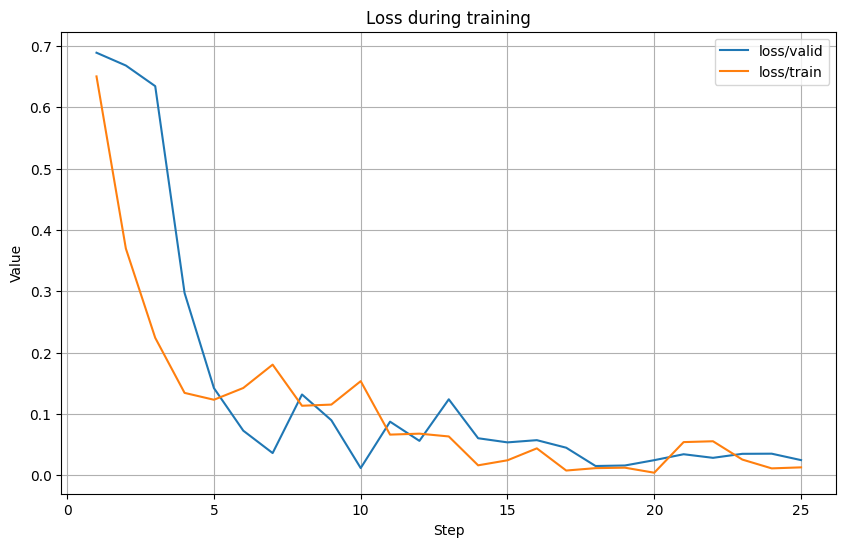

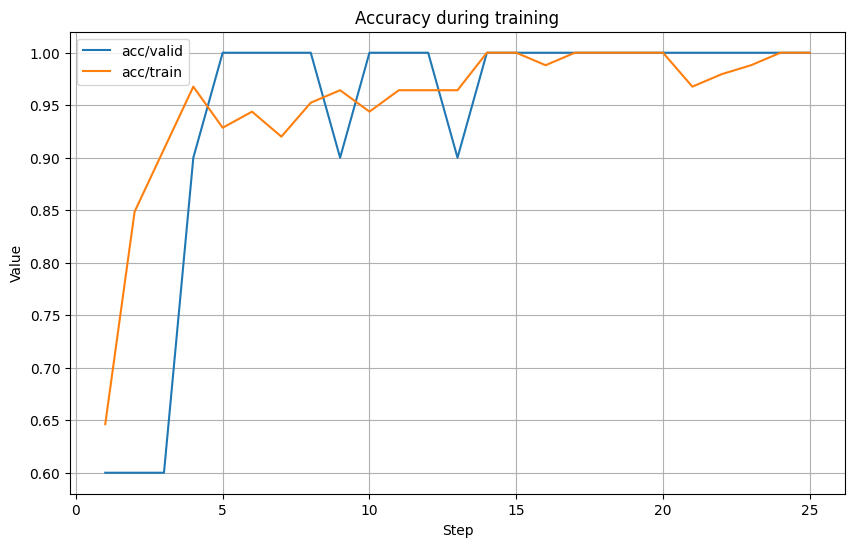

In [29]:
event_file = "/home/ulaval.ca/maelr5/scratch/parkinsons-results/xvector/vowel_a/FBANKs/1986/tb_logs/events.out.tfevents.1745099049.ul-val-pr-gpu05.l.ul.ca.1015678.0"
plot_training(event_file)



### Phrases Data

#### hparams file

In [32]:
%%file hparams_xvector_phrases_fbanks.yaml

# Your code here
# #################################
# Basic training parameters for digit classification with Xvector
#
# Author:
#  * Mirco Ravanelli 2021
# #################################

# Seed needs to be set at top of yaml, before objects with parameters are made
seed: 1986
__set_seed: !!python/object/apply:torch.manual_seed [!ref <seed>]

data_folder: !ref /home/ulaval.ca/maelr5/scratch/parkinsons
output_folder: !ref /home/ulaval.ca/maelr5/scratch/parkinsons-results/xvector/phrases/FBANKs/<seed>
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# Path where data manifest files are stored
train_annotation: /home/ulaval.ca/maelr5/parkinsons/train-phrases.json
valid_annotation: /home/ulaval.ca/maelr5/parkinsons/valid-phrases.json
test_annotation: /home/ulaval.ca/maelr5/parkinsons/test-phrases.json

# The train logger writes training statistics to a file, as well as stdout.
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

error_stats: !name:speechbrain.utils.metric_stats.MetricStats
    metric: !name:speechbrain.nnet.losses.classification_error
        reduction: batch

# Feature parameters
n_mels: 40

# Training Parameters
sample_rate: 16000
number_of_epochs: 25
batch_size: 12
lr_start: 0.001
lr_final: 0.0001
n_classes: 2
emb_dim: 128 # dimensionality of the embeddings
dataloader_options:
    batch_size: !ref <batch_size>

# Tensorboard logs
use_tensorboard: False
tensorboard_logs_folder: !ref <output_folder>/tb_logs/

# Feature extraction
compute_features: !new:speechbrain.lobes.features.Fbank
    n_mels: !ref <n_mels>

# Mean and std normalization of the input features
mean_var_norm: !new:speechbrain.processing.features.InputNormalization
    norm_type: global

# Embedding model: from variable size recordings gets a fixed size embedding vector
embedding_model: !new:speechbrain.lobes.models.Xvector.Xvector
    in_channels: !ref <n_mels>
    activation: !name:torch.nn.LeakyReLU
    tdnn_blocks: 5
    tdnn_channels: [64, 64, 64, 64, 128]
    tdnn_kernel_sizes: [5, 3, 3, 1, 1]
    tdnn_dilations: [1, 2, 3, 1, 1]
    lin_neurons: !ref <emb_dim>

# Clasifier applied on top of the embeddings
classifier: !new:speechbrain.lobes.models.Xvector.Classifier
    input_shape: [null, null, !ref <emb_dim>]
    activation: !name:torch.nn.LeakyReLU
    lin_blocks: 1
    lin_neurons: !ref <emb_dim>
    out_neurons: !ref <n_classes>

log_softmax: !new:speechbrain.nnet.activations.Softmax
    apply_log: True

# The first object passed to the Brain class is this "Epoch Counter"
# which is saved by the Checkpointer so that training can be resumed
# if it gets interrupted at any point.
epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

# Objects in "modules" dict will have their parameters moved to the correct
# device, as well as having train()/eval() called on them by the Brain class.
modules:
    compute_features: !ref <compute_features>
    mean_var_norm: !ref <mean_var_norm>
    embedding_model: !ref <embedding_model>
    classifier: !ref <classifier>

# This optimizer will be constructed by the Brain class after all parameters
# are moved to the correct device. Then it will be added to the checkpointer.
opt_class: !name:torch.optim.Adam
    lr: !ref <lr_start>

# This function manages learning rate annealing over the epochs.
# We here use the simple lr annealing method that linearly decreases
# the lr from the initial value to the final one.
lr_annealing: !new:speechbrain.nnet.schedulers.LinearScheduler
    initial_value: !ref <lr_start>
    final_value: !ref <lr_final>
    epoch_count: !ref <number_of_epochs>

# This object is used for saving the state of training both so that it
# can be resumed if it gets interrupted, and also so that the best checkpoint
# can be later loaded for evaluation or inference.
checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        embedding_model: !ref <embedding_model>
        classifier: !ref <classifier>
        normalizer: !ref <mean_var_norm>
        counter: !ref <epoch_counter>


Overwriting hparams_xvector_phrases_fbanks.yaml


#### train python file

We can use the same train_xvector_fbanks.py script for training

In [33]:
# Delete the output folder to start training from scratch (and not from a previous checkpoint).
# !rm -rf /home/ulaval.ca/maelr5/scratch/parkinsons-results/xvector/FBANKs/1986

import sys
# Run Training
!{sys.executable} train_xvector_fbanks.py hparams_xvector_phrases_fbanks.yaml --device='cuda:0' --number_of_epochs=25 --use_tensorboard=True


/home/ulaval.ca/maelr5/parkinsons/parksenv/lib/python3.11/site-packages/speechbrain/utils/autocast.py:188: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)
speechbrain.utils.quirks - Applied quirks (see `speechbrain.utils.quirks`): [allow_tf32, disable_jit_profiling]
speechbrain.utils.quirks - Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: /home/ulaval.ca/maelr5/scratch/parkinsons-results/xvector/phrases/FBANKs/1986
2025-04-19 17:58:00.517254: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-19 17:58:00.540725: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.c

#### plot the train/valid loss/accuracy during training:

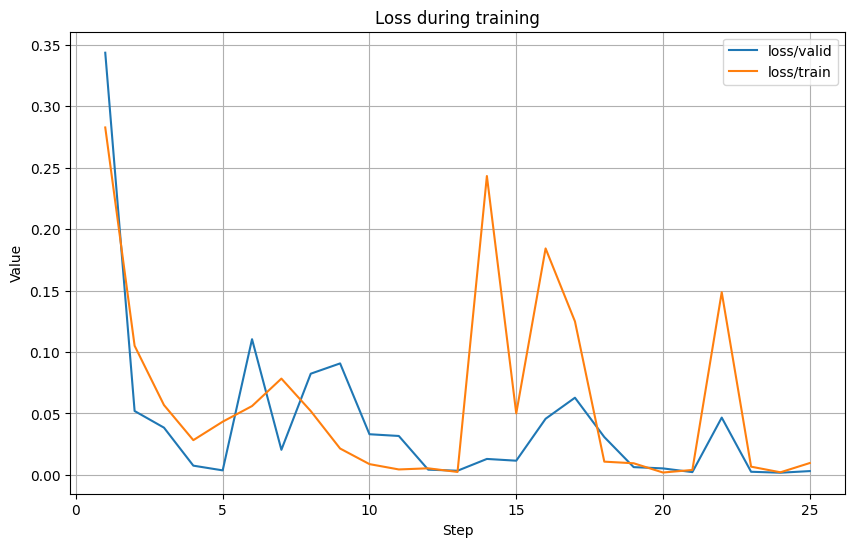

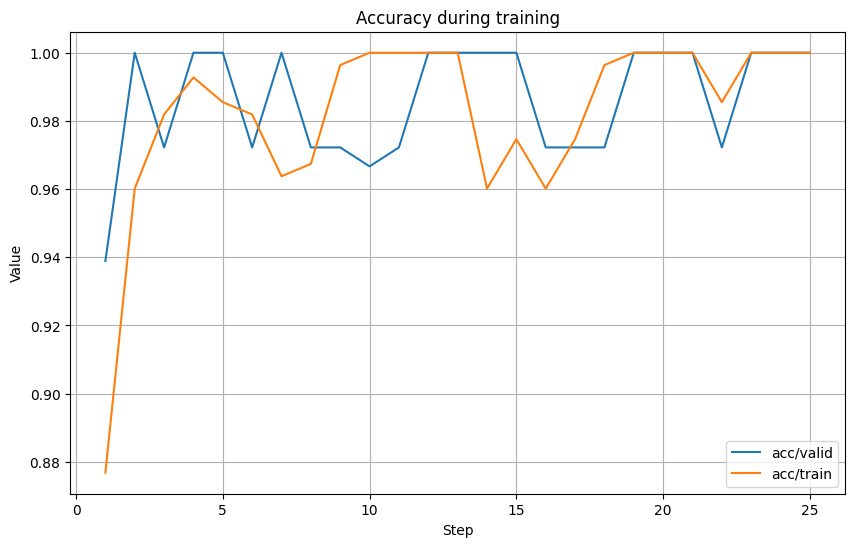

In [34]:
event_file = "/home/ulaval.ca/maelr5/scratch/parkinsons-results/xvector/phrases/FBANKs/1986/tb_logs/events.out.tfevents.1745099887.ul-val-pr-gpu05.l.ul.ca.1017234.0"
plot_training(event_file)

